In [16]:
# Plotting script for results
import os
import matplotlib.pyplot as plt
from utils.read_results_helpers import *
from utils.plotting_helpers import *

In [17]:
def plot_results(files_sorted, poi_results, color_dict, poi, sorted_technologies, outfile_suffix = ''):
    """
    Plot results, main plots are normalized cost and dispatch
    """

    # Create figure
    fig, ax = plt.subplots()

    if poi == 'dispatch':
        sorted_technologies['generators'].append('curtailment')

    # Flatten sorted_technologies dictionary to list
    sorted_components = [item for sublist in sorted_technologies.values() for item in sublist]

    # Loop over all case pickle files in all_firm_case folder
    max_result = 0
    for i,case_file in enumerate(files_sorted):

        results = poi_results[i]
        
        if i==0 or len([x for x in results.values() if x != 0]) > 0:
  
            # Stacked bar plot of results
            bottom_value = 0
            if case_file != files_sorted[-1]:
                x_tick_label = files_sorted[i+1].replace('all_firm', '').replace('.pickle', '').replace('_{0}_'.format(i), '')
                if "CO2" in x_tick_label:
                    x_tick_label = "direct air capture"
            else:
                if "no_generators" in outfile_suffix:
                    x_tick_label = "no storage left"
                else:
                    x_tick_label = "only solar and wind"
            x_tick_label = x_tick_label.replace('_', ' ')

            for component in sorted_components:

                if "no_generators" in outfile_suffix and (component == 'CO2 storage tank' or component == 'direct air capture'):
                    continue
                if not case_file == 'all_firm_all.pickle':
                    if component not in results or results[component] == 0:
                        continue
                
                if poi == 'dispatch' and not component in sorted_technologies['generators']:
                    continue

                hatched, fill_color, hatch_color = get_hatching_color(component, sorted_technologies, color_dict)

                ax.bar(x_tick_label, results[component], width=0.25, color=fill_color, hatch=hatched,
                edgecolor=hatch_color, bottom=bottom_value, label=component)

                bottom_value += results[component]

            # Get max result to determine y-axis limits
            if sum(results.values()) > max_result:
                max_result = sum(results.values())
            
            # Get legend handles and labels for all_firm_all case
            if case_file == 'all_firm_all.pickle':
                handles, labels = ax.get_legend_handles_labels()
                labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: sorted_components.index(t[0])))

    # Plot labels
    ax = set_x_y_labels(outfile_suffix, poi, ax)

    # Set title
    ax = set_title(outfile_suffix, ax, poi)


    ax.set_ylim(0, 1.2*max_result)
  
    # Order the legend entries into the columns
    if "no_generators" in outfile_suffix:
        sorted_technologies['demand_handling'] = [x for x in sorted_technologies['demand_handling'] if x != 'CO2 storage tank' and x != 'direct air capture']
    
    # Legend
    ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0., -0.42, 1., 0.), ncol=3, fontsize=7)


    # Save plot
    if not os.path.exists('figures'):
        os.makedirs('figures')

    # save jpeg with higher resolution
    plt.savefig('figures/total_{0}{1}.jpeg'.format(poi, outfile_suffix), dpi=400, bbox_inches='tight')
    plt.show()

In [18]:
# Results directory
out_suff = '_most'
results_dir = 'output_data/all_firm_case' + out_suff + '/plotting/' 

# Technology categories
generators = ['onwind', 'solar-utility', 'natgas', 'natgas_wCCS', 'nuclear', 'beccs', 'hydro', 'geothermal']
storage_unconstrained = ['hydrogen_store', 'concrete_store', 'highT_molten_salt_store', 'liquid_air_store', 'lowT_molten_salt_store', 'pumped_heat_store', 'sand_store']
storage_constrained = ['battery storage', 'lead_acid_store', 'lithium_ion_lfp_store', 'lithium_ion_nmc_store', 'ni_zn_store', 'redox_store', 'zn_air_store', 'zn_br_flow_store', 'zn_br_nonflow_store', 'compressed_air_store', 'gravity_brick_store', 'gravity_aboveground_store', 'gravity_underground_store', 'phs_store']
demand_handling = ['load shedding', 'load shifting backward', 'load shifting forward', 'CO2 storage tank', 'direct air capture']

technologies = {'generators': generators, 'storage_unconstrained': storage_unconstrained, 'storage_constrained': storage_constrained, 'demand_handling': demand_handling}

# Get color map
color_dict = get_colors()

In [19]:
# Get all case pickle files
files_sorted = get_files(results_dir)

# Parameters to plot
compute_pois = ['cost', 'capacity', 'normalized_cost', 'dispatch']

# Get results to be plotted
results_dict = {}
for poi in compute_pois:
    # Normalized cost is computed by dividing total cost by total demand
    if poi == 'normalized_cost':
        use_results = results_dict['cost']
    else:
        use_results = []

    results_dict[poi] = compute_results(results_dir, poi, files_sorted, pass_results=use_results)


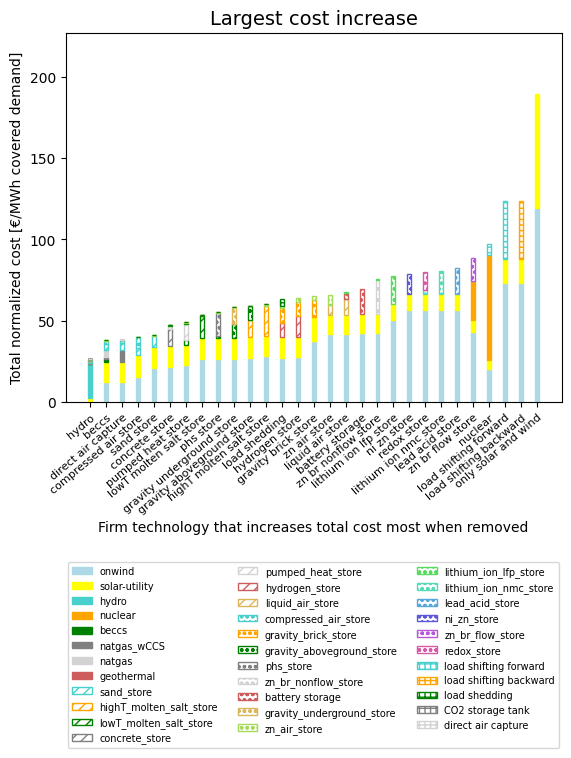

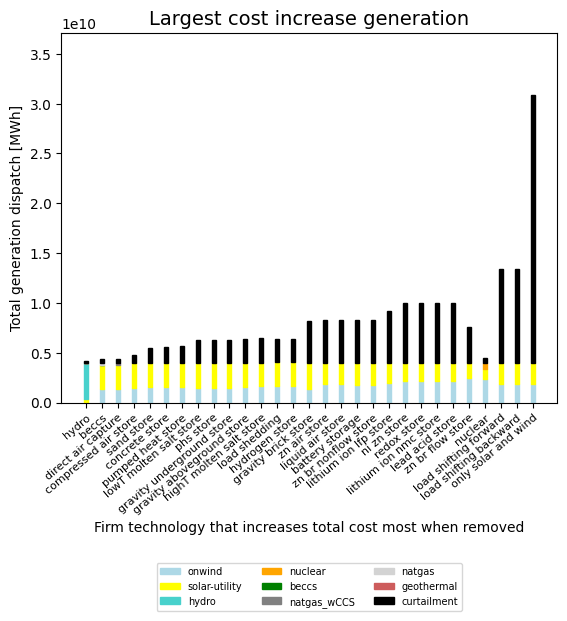

In [20]:
# Always order components the same way as they are ordered by mean normalized cost, except for wind and solar that come first

files_base = [f for f in os.listdir('output_data/all_firm_case_most/plotting') if f.endswith('.pickle')]
sorted_techs = calculate_mean_cost_comp_list(technologies, results_dict['normalized_cost'])

plot_pois = ['normalized_cost', 'dispatch']
# Plot
for poi in plot_pois:
    plot_results(files_sorted, results_dict[poi], color_dict, poi, sorted_techs, outfile_suffix=out_suff)